### Required Libraries

In [1]:
library(CellChat)
library(ComplexHeatmap)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu

In [2]:
packageVersion("CellChat")

[1] ‘1.1.2’

In [3]:
packageVersion("ComplexHeatmap")

[1] ‘2.10.0’

### Modifying netVisual_bubble

In [4]:
#We are modifying the netVisual_buble from Cellchat to give some more flexability in explorting receptor_ligand pairs in multiple datasets. 

#These options were added (value shown are the default):
#color.heatmap = c("Spectral","viridis","Reds") - originally Reds was not included. Use direction = 1 or -1 to change the color direction
#text_size.x=8 - changes the text size of the x-axis
#text_size.y=8 - changes the text size of the y-axis
#pch=16 - changes the type of dot
#cex=1 - changes the size of the dot. Change to NULL for the size to reflect p-value
#order=NULL - use TRUE to automatically sort by dataset or c("sender1 -> receiver1 (datasetX)","sender1 -> receiver1 (datasetZ)","sender1 -> receiver1 (datasetY)"...) for manual sorting

#Text size and point options were added to this portion of the function:
#(to swap the axis, find this portion in the function and swap y and x in aes). Note that are two, one for cex=NULL and another when cex is a numeric value

# g <- ggplot(df, aes(y = source.target, x = interaction_name_2, color = prob, size = pval)) +
#    geom_point(pch = pch,cex=cex) +
#    theme_linedraw() + theme(panel.grid.major = element_blank()) +
#    theme(axis.text.x = element_text(angle = angle.x, hjust= hjust.x, vjust = vjust.x,size=text_size.x),
#          axis.text.y = element_text(angle = angle.y, hjust= hjust.y, vjust = vjust.y,size=text_size.y),
#          axis.title.x = element_blank(),
#          axis.title.y = element_blank()) +
#    scale_x_discrete(position = "bottom")


#The following was added to the function to sort interactions by dataset:

#  if (!is.null(order)){
      
#     df=df[
#     with(df, order(df$dataset,df$target)),
#     ]
#     df$source.target=paste0(df$group.names," (",df$dataset,")")
#      if (order==TRUE){
#     order=unique(df$source.target)
#          }
#     df$source.target <- factor(df$source.target,levels = c(order))

#  }

### Define a new function

In [5]:
netVisual_bubble_2 <- function(object, sources.use = NULL, targets.use = NULL, signaling = NULL, pairLR.use = NULL, color.heatmap = c("Spectral","viridis","Reds"), n.colors = 10, direction = -1, thresh = 0.05,
                             comparison = NULL, group = NULL, remove.isolate = FALSE, max.dataset = NULL, min.dataset = NULL,
                             min.quantile = 0, max.quantile = 1, line.on = TRUE, line.size = 0.2, color.text.use = TRUE, color.text = NULL,
                             title.name = NULL, font.size = 10, font.size.title = 10, show.legend = TRUE,
                             grid.on = TRUE, color.grid = "grey90", angle.x = 90, vjust.x = NULL, hjust.x = NULL,angle.y = 0, vjust.y = NULL, hjust.y = NULL,
                             return.data = FALSE,text_size.x=8,text_size.y=8,pch=16,cex=1,order=NULL){
  color.heatmap <- match.arg(color.heatmap)
  if (is.list(object@net[[1]])) {
    message("Comparing communications on a merged object \n")
  } else {
    message("Comparing communications on a single object \n")
  }
  if (is.null(vjust.x) | is.null(hjust.x)) {
    angle=c(0, 45, 90)
    hjust=c(0, 1, 1)
    vjust=c(0, 1, 0.5)
    vjust.x = vjust[angle == angle.x]
    hjust.x = hjust[angle == angle.x]
  }
  if (length(color.heatmap) == 1) {
    color.use <- tryCatch({
      RColorBrewer::brewer.pal(n = n.colors, name = color.heatmap)
    }, error = function(e) {
      scales::viridis_pal(option = color.heatmap, direction = -1)(n.colors)
    })
  } else {
    color.use <- color.heatmap
  }
  if (direction == -1) {
    color.use <- rev(color.use)
  }

  if (is.null(comparison)) {
    cells.level <- levels(object@idents)
    if (is.numeric(sources.use)) {
      sources.use <- cells.level[sources.use]
    }
    if (is.numeric(targets.use)) {
      targets.use <- cells.level[targets.use]
    }
    df.net <- subsetCommunication(object, slot.name = "net",
                                  sources.use = sources.use, targets.use = targets.use,
                                  signaling = signaling,
                                  pairLR.use = pairLR.use,
                                  thresh = thresh)
    df.net$source.target <- paste(df.net$source, df.net$target, sep = " -> ")
    source.target <- paste(rep(sources.use, each = length(targets.use)), targets.use, sep = " -> ")
    source.target.isolate <- setdiff(source.target, unique(df.net$source.target))
    if (length(source.target.isolate) > 0) {
      df.net.isolate <- as.data.frame(matrix(NA, nrow = length(source.target.isolate), ncol = ncol(df.net)))
      colnames(df.net.isolate) <- colnames(df.net)
      df.net.isolate$source.target <- source.target.isolate
      df.net.isolate$interaction_name_2 <- df.net$interaction_name_2[1]
      df.net.isolate$pval <- 1
      a <- stringr::str_split(df.net.isolate$source.target, " -> ", simplify = T)
      df.net.isolate$source <- as.character(a[, 1])
      df.net.isolate$target <- as.character(a[, 2])
      df.net <- rbind(df.net, df.net.isolate)
    }

    df.net$pval[df.net$pval > 0.05] = 1
    df.net$pval[df.net$pval > 0.01 & df.net$pval <= 0.05] = 2
    df.net$pval[df.net$pval <= 0.01] = 3
    df.net$prob[df.net$prob == 0] <- NA
    df.net$prob.original <- df.net$prob
    df.net$prob <- -1/log(df.net$prob)

    idx1 <- which(is.infinite(df.net$prob) | df.net$prob < 0)
    if (sum(idx1) > 0) {
      values.assign <- seq(max(df.net$prob, na.rm = T)*1.1, max(df.net$prob, na.rm = T)*1.5, length.out = length(idx1))
      position <- sort(prob.original[idx1], index.return = TRUE)$ix
      df.net$prob[idx1] <- values.assign[match(1:length(idx1), position)]
    }
    # rownames(df.net) <- df.net$interaction_name_2

    df.net$source <- factor(df.net$source, levels = cells.level[cells.level %in% unique(df.net$source)])
    df.net$target <- factor(df.net$target, levels = cells.level[cells.level %in% unique(df.net$target)])
    group.names <- paste(rep(levels(df.net$source), each = length(levels(df.net$target))), levels(df.net$target), sep = " -> ")

    df.net$interaction_name_2 <- as.character(df.net$interaction_name_2)
    df.net <- with(df.net, df.net[order(interaction_name_2),])
    df.net$interaction_name_2 <- factor(df.net$interaction_name_2, levels = unique(df.net$interaction_name_2))
    cells.order <- group.names
    df.net$source.target <- factor(df.net$source.target, levels = cells.order)
    df <- df.net
  } else {
    dataset.name <- names(object@net)
    df.net.all <- subsetCommunication(object, slot.name = "net",
                                      sources.use = sources.use, targets.use = targets.use,
                                      signaling = signaling,
                                      pairLR.use = pairLR.use,
                                      thresh = thresh)
    df.all <- data.frame()
    for (ii in 1:length(comparison)) {
      cells.level <- levels(object@idents[[comparison[ii]]])
      if (is.numeric(sources.use)) {
        sources.use <- cells.level[sources.use]
      }
      if (is.numeric(targets.use)) {
        targets.use <- cells.level[targets.use]
      }

      df.net <- df.net.all[[comparison[ii]]]
      df.net$interaction_name_2 <- as.character(df.net$interaction_name_2)
      df.net$source.target <- paste(df.net$source, df.net$target, sep = " -> ")
      source.target <- paste(rep(sources.use, each = length(targets.use)), targets.use, sep = " -> ")
      source.target.isolate <- setdiff(source.target, unique(df.net$source.target))
      if (length(source.target.isolate) > 0) {
        df.net.isolate <- as.data.frame(matrix(NA, nrow = length(source.target.isolate), ncol = ncol(df.net)))
        colnames(df.net.isolate) <- colnames(df.net)
        df.net.isolate$source.target <- source.target.isolate
        df.net.isolate$interaction_name_2 <- df.net$interaction_name_2[1]
        df.net.isolate$pval <- 1
        a <- stringr::str_split(df.net.isolate$source.target, " -> ", simplify = T)
        df.net.isolate$source <- as.character(a[, 1])
        df.net.isolate$target <- as.character(a[, 2])
        df.net <- rbind(df.net, df.net.isolate)
      }

      df.net$source <- factor(df.net$source, levels = cells.level[cells.level %in% unique(df.net$source)])
      df.net$target <- factor(df.net$target, levels = cells.level[cells.level %in% unique(df.net$target)])
      group.names <- paste(rep(levels(df.net$source), each = length(levels(df.net$target))), levels(df.net$target), sep = " -> ")
      group.names0 <- group.names
      group.names <- paste0(group.names0, " (", dataset.name[comparison[ii]], ")")

      if (nrow(df.net) > 0) {
        df.net$pval[df.net$pval > 0.05] = 1
        df.net$pval[df.net$pval > 0.01 & df.net$pval <= 0.05] = 2
        df.net$pval[df.net$pval <= 0.01] = 3
        df.net$prob[df.net$prob == 0] <- NA
        df.net$prob.original <- df.net$prob
        df.net$prob <- -1/log(df.net$prob)
      } else {
        df.net <- as.data.frame(matrix(NA, nrow = length(group.names), ncol = 5))
        colnames(df.net) <- c("interaction_name_2","source.target","prob","pval","prob.original")
        df.net$source.target <- group.names0
      }
      # df.net$group.names <- sub(paste0(' \\(',dataset.name[comparison[ii]],'\\)'),'',as.character(df.net$source.target))
      df.net$group.names <- as.character(df.net$source.target)
      df.net$source.target <- paste0(df.net$source.target, " (", dataset.name[comparison[ii]], ")")
      df.net$dataset <- dataset.name[comparison[ii]]
      df.all <- rbind(df.all, df.net)
    }
    if (nrow(df.all) == 0) {
      stop("No interactions are detected. Please consider changing the cell groups for analysis. ")
    }

    idx1 <- which(is.infinite(df.all$prob) | df.all$prob < 0)
    if (sum(idx1) > 0) {
      values.assign <- seq(max(df.all$prob, na.rm = T)*1.1, max(df.all$prob, na.rm = T)*1.5, length.out = length(idx1))
      position <- sort(df.all$prob.original[idx1], index.return = TRUE)$ix
      df.all$prob[idx1] <- values.assign[match(1:length(idx1), position)]
    }

    df.all$interaction_name_2[is.na(df.all$interaction_name_2)] <- df.all$interaction_name_2[!is.na(df.all$interaction_name_2)][1]

    df <- df.all
    df <- with(df, df[order(interaction_name_2),])
    df$interaction_name_2 <- factor(df$interaction_name_2, levels = unique(df$interaction_name_2))

    cells.order <- c()
    dataset.name.order <- c()
    for (i in 1:length(group.names0)) {
      for (j in 1:length(comparison)) {
        cells.order <- c(cells.order, paste0(group.names0[i], " (", dataset.name[comparison[j]], ")"))
        dataset.name.order <- c(dataset.name.order, dataset.name[comparison[j]])
      }
    }
    df$source.target <- factor(df$source.target, levels = cells.order)
  }

  min.cutoff <- quantile(df$prob, min.quantile,na.rm= T)
  max.cutoff <- quantile(df$prob, max.quantile,na.rm= T)
  df$prob[df$prob < min.cutoff] <- min.cutoff
  df$prob[df$prob > max.cutoff] <- max.cutoff


  if (remove.isolate) {
    df <- df[!is.na(df$prob), ]
    line.on <- FALSE
  }
  if (!is.null(max.dataset)) {
    # line.on <- FALSE
    # df <- df[!is.na(df$prob),]
    signaling <- as.character(unique(df$interaction_name_2))
    for (i in signaling) {
      df.i <- df[df$interaction_name_2 == i, ,drop = FALSE]
      cell <- as.character(unique(df.i$group.names))
      for (j in cell) {
        df.i.j <- df.i[df.i$group.names == j, , drop = FALSE]
        values <- df.i.j$prob
        idx.max <- which(values == max(values, na.rm = T))
        idx.min <- which(values == min(values, na.rm = T))
        #idx.na <- c(which(is.na(values)), which(!(dataset.name[comparison] %in% df.i.j$dataset)))
        dataset.na <- c(df.i.j$dataset[is.na(values)], setdiff(dataset.name[comparison], df.i.j$dataset))
        if (length(idx.max) > 0) {
          if (!(df.i.j$dataset[idx.max] %in% dataset.name[max.dataset])) {
            df.i.j$prob <- NA
          } else if ((idx.max != idx.min) & !is.null(min.dataset)) {
            if (!(df.i.j$dataset[idx.min] %in% dataset.name[min.dataset])) {
              df.i.j$prob <- NA
            } else if (length(dataset.na) > 0 & sum(!(dataset.name[min.dataset] %in% dataset.na)) > 0) {
              df.i.j$prob <- NA
            }
          }
        }
        df.i[df.i$group.names == j, "prob"] <- df.i.j$prob
      }
      df[df$interaction_name_2 == i, "prob"] <- df.i$prob
    }
    #df <- df[!is.na(df$prob), ]
  }
  if (remove.isolate) {
    df <- df[!is.na(df$prob), ]
    line.on <- FALSE
  }
  if (nrow(df) == 0) {
    stop("No interactions are detected. Please consider changing the cell groups for analysis. ")
  }
  df$interaction_name_2 <- factor(df$interaction_name_2, levels = unique(df$interaction_name_2))
  df$source.target = droplevels(df$source.target, exclude = setdiff(levels(df$source.target),unique(df$source.target)))
   
  if (!is.null(order)){
      
     df=df[
     with(df, order(df$dataset,df$target)),
     ]
     df$source.target=paste0(df$group.names," (",df$dataset,")")
      if (order==TRUE){
     order=unique(df$source.target)
          }
     df$source.target <- factor(df$source.target,levels = c(order))

  }

    if (!is.null(cex)){
   
  g <- ggplot(df, aes(y = source.target, x = interaction_name_2, color = prob, size = pval)) +
    geom_point(pch = pch,cex=cex) +
    theme_linedraw() + theme(panel.grid.major = element_blank()) +
    theme(axis.text.x = element_text(angle = angle.x, hjust= hjust.x, vjust = vjust.x,size=text_size.x),
          axis.text.y = element_text(angle = angle.y, hjust= hjust.y, vjust = vjust.y,size=text_size.y),
          axis.title.x = element_blank(),
          axis.title.y = element_blank()) +
    scale_x_discrete(position = "bottom")
        }
    
     if (is.null(cex)){
   
  g <- ggplot(df, aes(y = source.target, x = interaction_name_2, color = prob, size = pval)) +
    geom_point(pch = pch) +
    theme_linedraw() + theme(panel.grid.major = element_blank()) +
    theme(axis.text.x = element_text(angle = angle.x, hjust= hjust.x, vjust = vjust.x,size=text_size.x),
          axis.text.y = element_text(angle = angle.y, hjust= hjust.y, vjust = vjust.y,size=text_size.y),
          axis.title.x = element_blank(),
          axis.title.y = element_blank()) +
    scale_x_discrete(position = "bottom")
        }

  values <- c(1,2,3); names(values) <- c("p > 0.05", "0.01 < p < 0.05","p < 0.01")

  g <- g + scale_radius(range = c(min(df$pval), max(df$pval)), breaks = sort(unique(df$pval)),labels = names(values)[values %in% sort(unique(df$pval))], name = "p-value")
  #g <- g + scale_radius(range = c(1,3), breaks = values,labels = names(values), name = "p-value")
  if (min(df$prob, na.rm = T) != max(df$prob, na.rm = T)) {
    g <- g + scale_colour_gradientn(colors = colorRampPalette(color.use)(99), na.value = "white", limits=c(quantile(df$prob, 0,na.rm= T), quantile(df$prob, 1,na.rm= T)),
                                    breaks = c(quantile(df$prob, 0,na.rm= T), quantile(df$prob, 1,na.rm= T)), labels = c("min","max")) +
      guides(color = guide_colourbar(barwidth = 0.5, title = "Commun. Prob."))
  } else {
    g <- g + scale_colour_gradientn(colors = colorRampPalette(color.use)(99), na.value = "white") +
      guides(color = guide_colourbar(barwidth = 0.5, title = "Commun. Prob."))
  }

  g <- g + theme(text = element_text(size = font.size),plot.title = element_text(size=font.size.title)) +
    theme(legend.title = element_text(size = 8), legend.text = element_text(size = 6))

  if (grid.on) {
    if (length(unique(df$source.target)) > 1) {
      g <- g + geom_vline(xintercept=seq(1.5, length(unique(df$source.target))-0.5, 1),lwd=0.1,colour=color.grid)
    }
    if (length(unique(df$interaction_name_2)) > 1) {
      g <- g + geom_hline(yintercept=seq(1.5, length(unique(df$interaction_name_2))-0.5, 1),lwd=0.1,colour=color.grid)
    }
  }
  if (!is.null(title.name)) {
    g <- g + ggtitle(title.name) + theme(plot.title = element_text(hjust = 0.5))
  }

  if (!is.null(comparison)) {
    if (line.on) {
      xintercept = seq(0.5+length(dataset.name[comparison]), length(group.names0)*length(dataset.name[comparison]), by = length(dataset.name[comparison]))
      g <- g + geom_vline(xintercept = xintercept, linetype="dashed", color = "grey60", size = line.size)
    }
    if (color.text.use) {
      if (is.null(group)) {
        group <- 1:length(comparison)
        names(group) <- dataset.name[comparison]
      }
      if (is.null(color.text)) {
        color <- ggPalette(length(unique(group)))
      } else {
        color <- color.text
      }
      names(color) <- names(group[!duplicated(group)])
      color <- color[group]
      #names(color) <- dataset.name[comparison]
      dataset.name.order <- levels(df$source.target)
      dataset.name.order <- stringr::str_match(dataset.name.order, "\\(.*\\)")
      dataset.name.order <- stringr::str_sub(dataset.name.order, 2, stringr::str_length(dataset.name.order)-1)
      xtick.color <- color[dataset.name.order]
      g <- g + theme(axis.text.x = element_text(colour = xtick.color))
    }
  }
  if (!show.legend) {
    g <- g + theme(legend.position = "none")
  }
  if (return.data) {
    return(list(communication = df, gg.obj = g))
  } else {
    return(g)
  }

}

### Load datasets

In [6]:
control_lv<- readRDS("/rds/general/user/aalmeid2/projects/cardiac_single_cell_biology/live/DCM_project/global_20210305/CellChat/Cellchat_V7/cellchat_global_V7_control_LV_CELLSTATES.rds")
pvneg_lv<- readRDS("/rds/general/user/aalmeid2/projects/cardiac_single_cell_biology/live/DCM_project/global_20210305/CellChat/Cellchat_V7/cellchat_global_V7_PVneg_LV_CELLSTATES.rds")
pkp2_lv<- readRDS("/rds/general/user/aalmeid2/projects/cardiac_single_cell_biology/live/DCM_project/global_20210305/CellChat/Cellchat_V7/cellchat_global_V7_PKP2_LV_CELLSTATES.rds")
ttn_lv<- readRDS("/rds/general/user/aalmeid2/projects/cardiac_single_cell_biology/live/DCM_project/global_20210305/CellChat/Cellchat_V7/cellchat_global_V7_TTN_LV_CELLSTATES.rds")
lmna_lv<- readRDS("/rds/general/user/aalmeid2/projects/cardiac_single_cell_biology/live/DCM_project/global_20210305/CellChat/Cellchat_V7/cellchat_global_V7_LMNA_LV_CELLSTATES.rds")
rbm20_lv<- readRDS("/rds/general/user/aalmeid2/projects/cardiac_single_cell_biology/live/DCM_project/global_20210305/CellChat/Cellchat_V7/cellchat_global_V7_RBM20_LV_CELLSTATES.rds")

### Create merged object

In [7]:
object.list <- list(Control = control_lv, RBM20 = rbm20_lv, PVneg = pvneg_lv, PKP2 = pkp2_lv, TTN = ttn_lv, LMNA = lmna_lv)
master_lv <- mergeCellChat(object.list, add.names = names(object.list))


Merge the following slots: 'data.signaling','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



### Using order=TRUE - sorting by dataset

Comparing communications on a merged object 




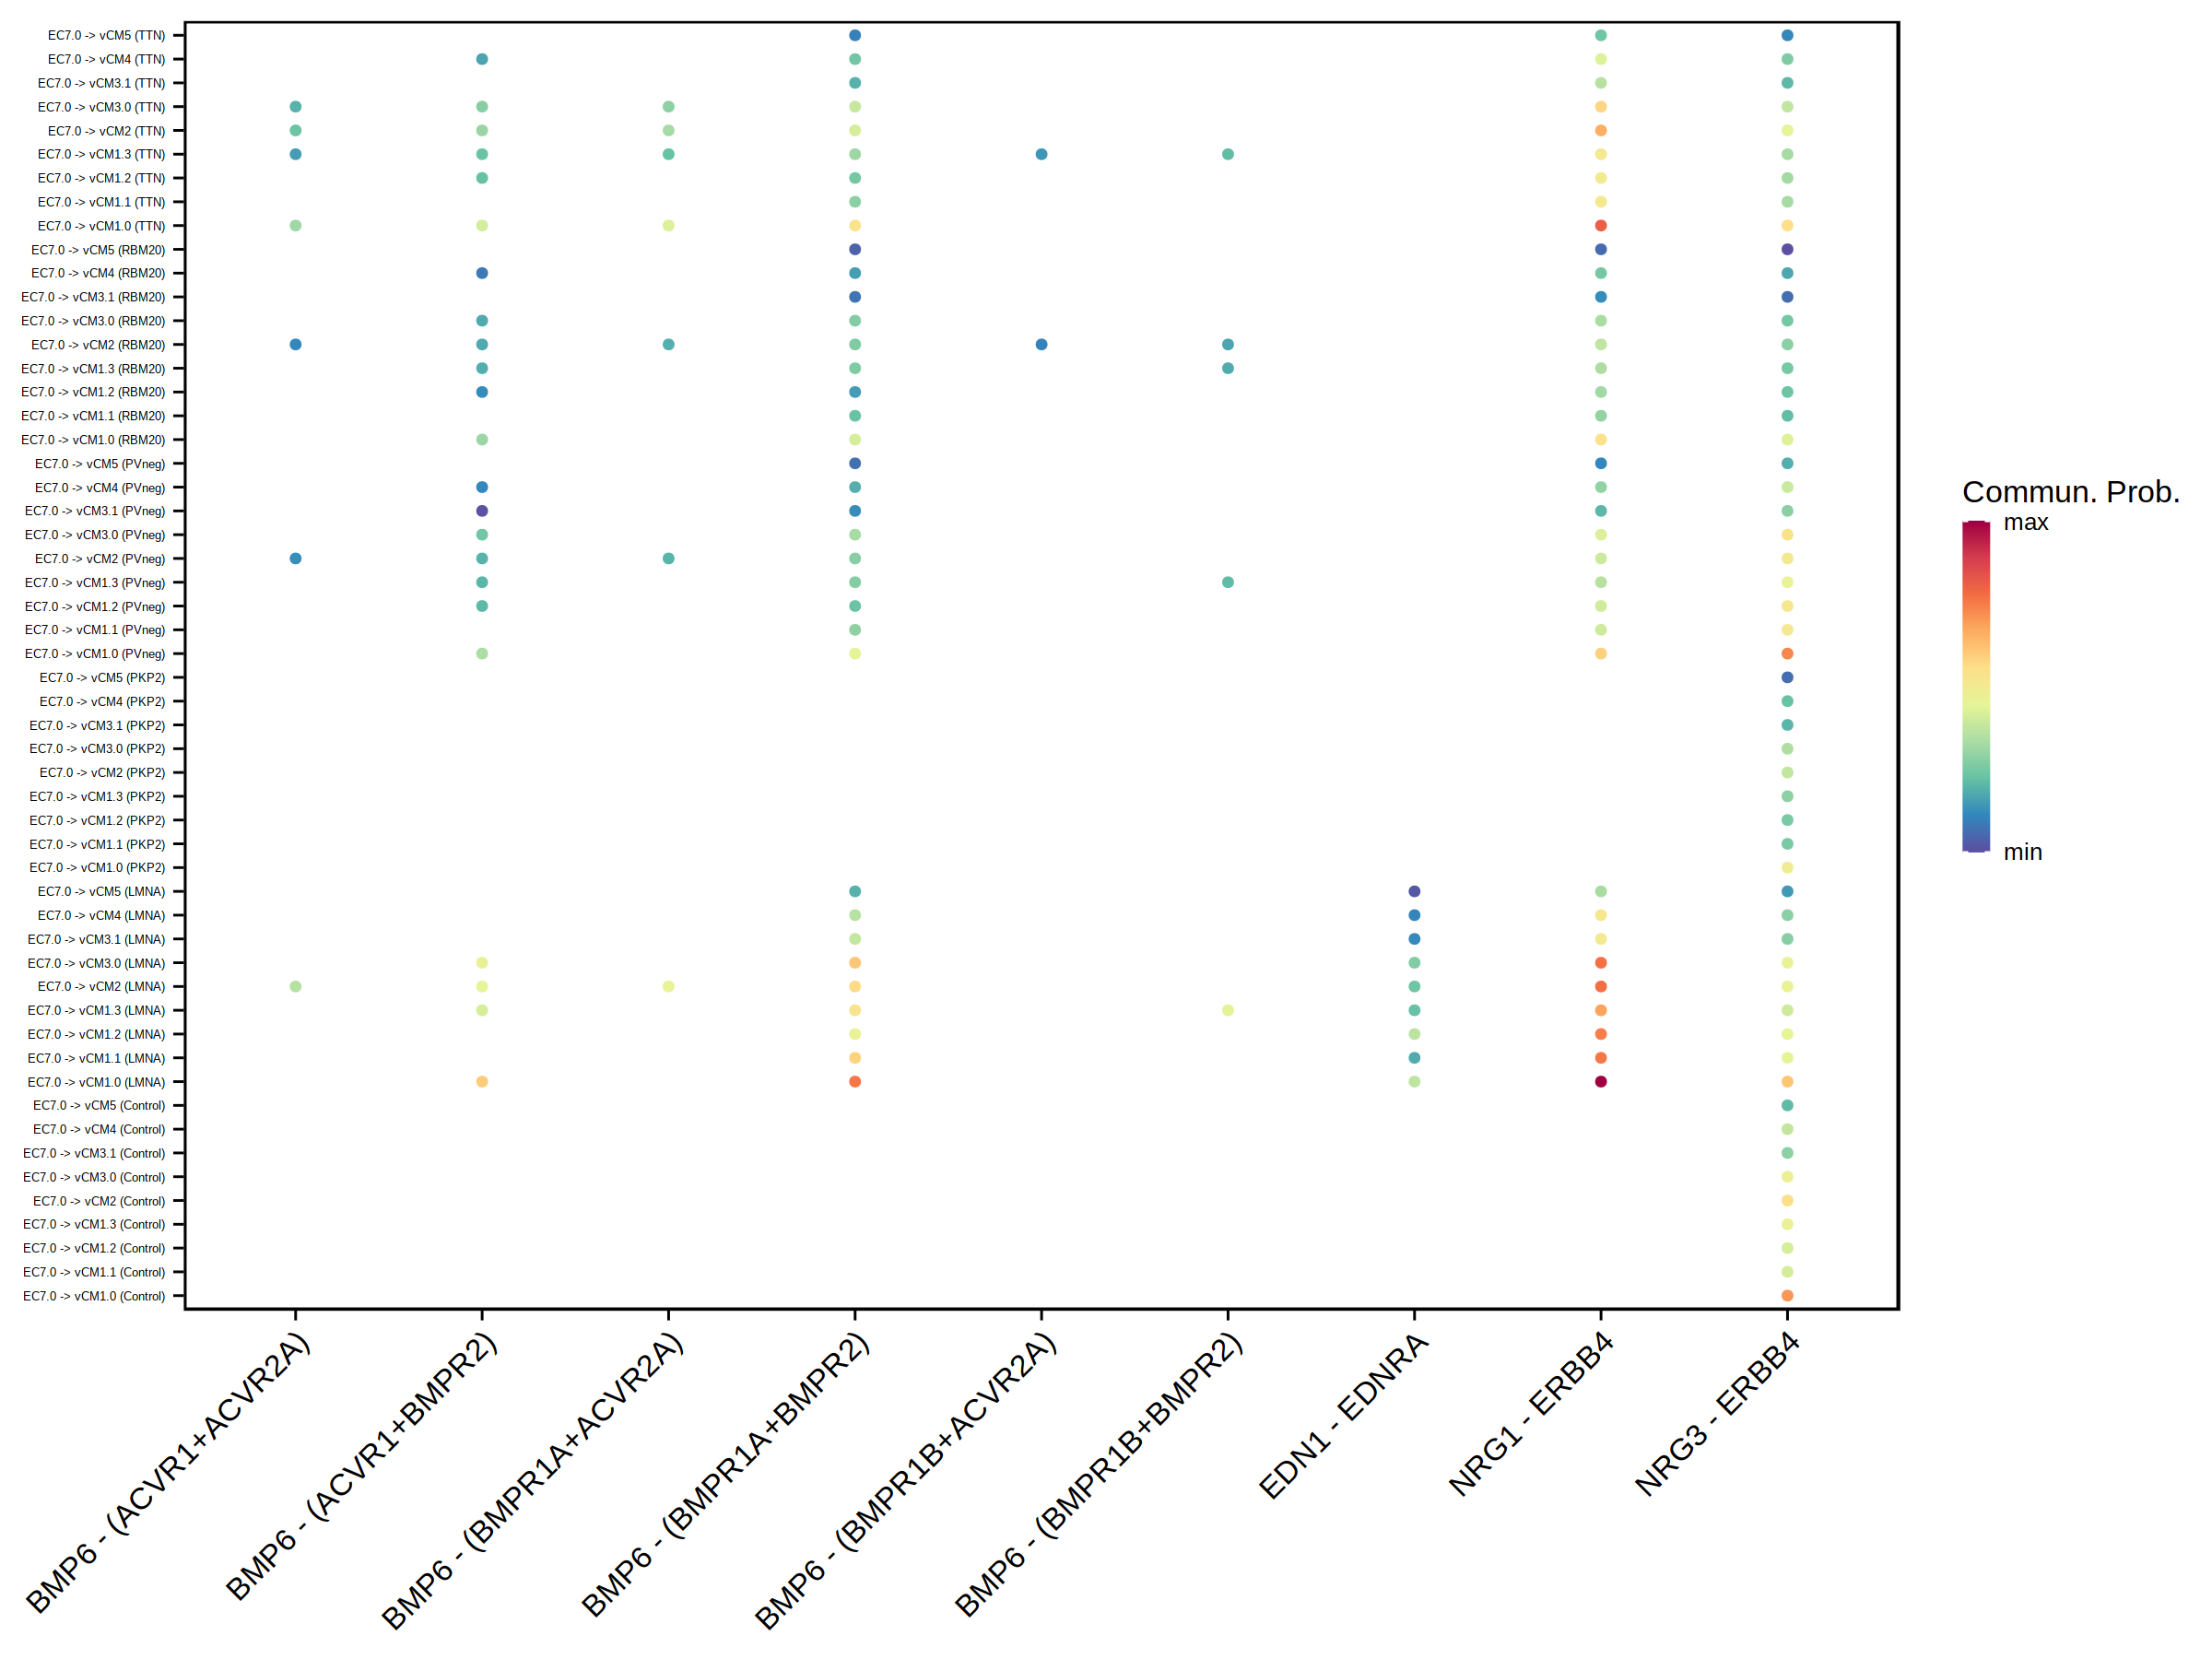

In [8]:
#pdf(width=8,height=6,file="cellchat_ec7_cm_lmna_lv.pdf")

options(repr.plot.width =8, repr.plot.height = 6, repr.plot.res = 300)

netVisual_bubble_2(master_lv, sources.use = "EC7.0",comparison = c(1, 2,3,4,5,6),targets.use = c("vCM1.0","vCM1.1","vCM1.2","vCM1.3","vCM2","vCM3.0","vCM3.1","vCM4","vCM5"), angle.x = 45,  signaling = c("NRG","EDN","BMP")
,text_size.y=3,pch=20,color.heatmap="Spectral",direction=-1,grid.on=FALSE,line.on=FALSE, color.text.use=FALSE,order=TRUE)


#dev.off()

### Using order=NULL - ordered by sender-receiver (cellchat default)

Comparing communications on a merged object 




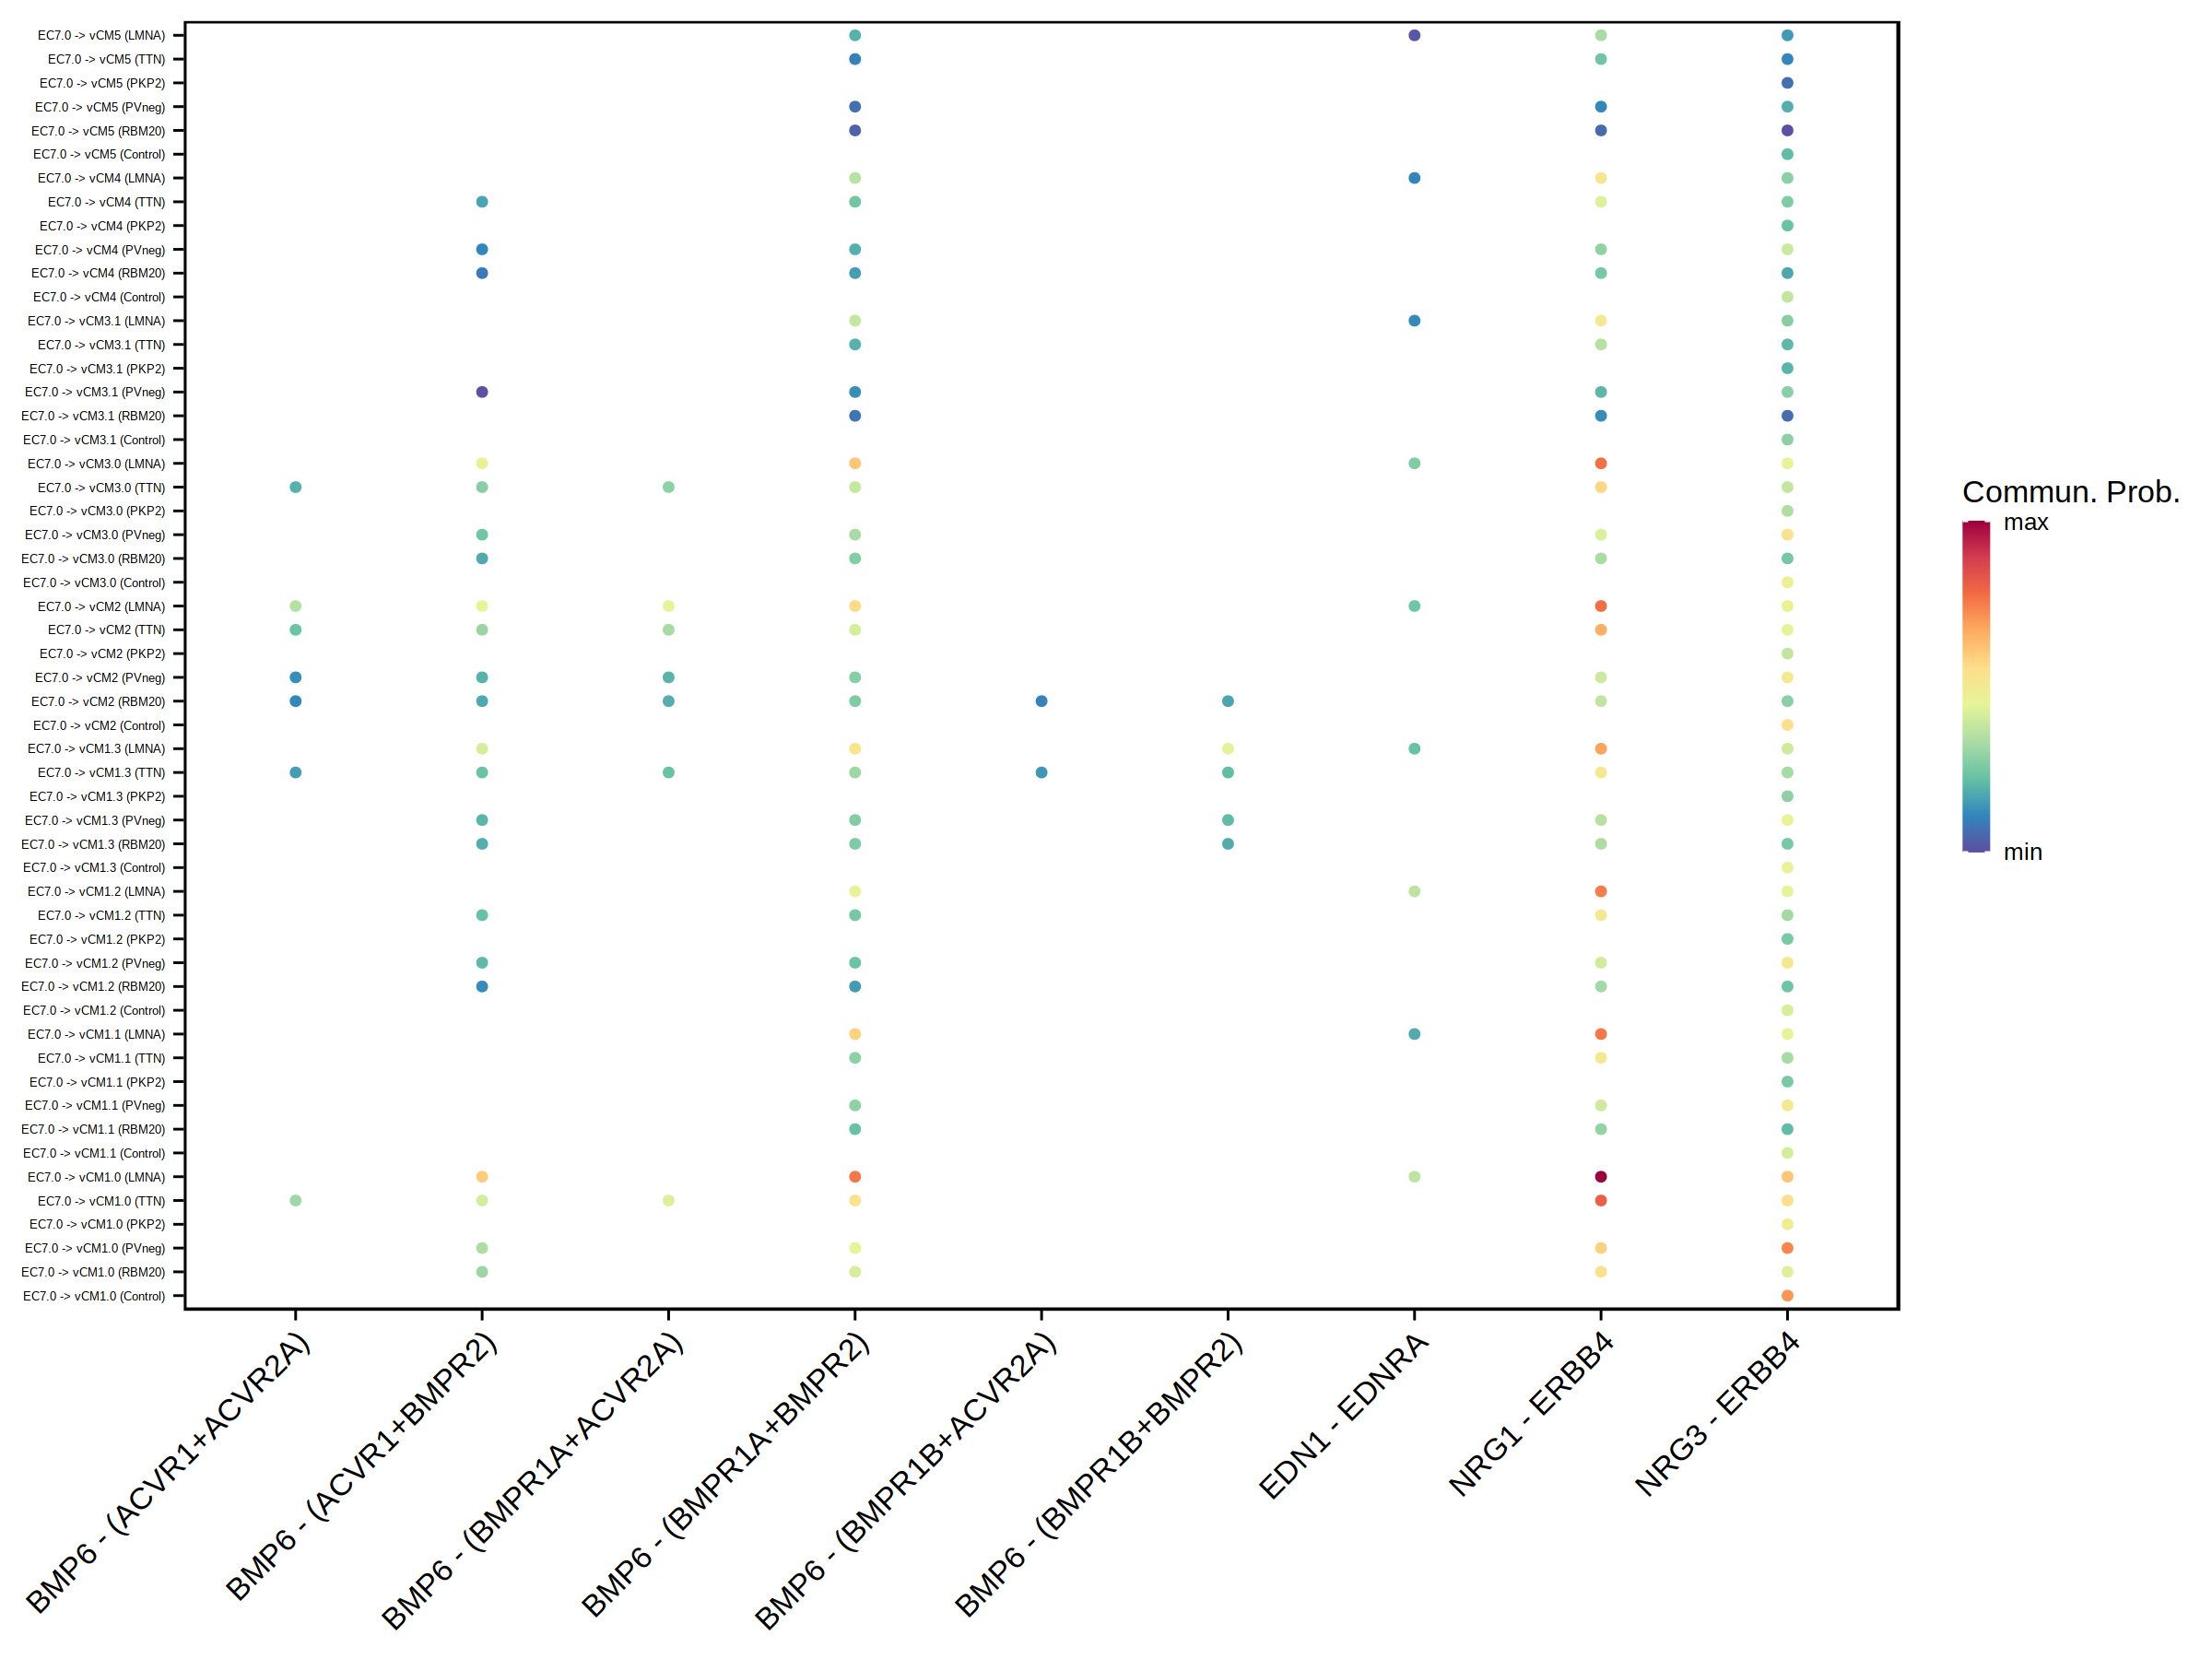

In [9]:
#pdf(width=8,height=6,file="cellchat_ec7_cm_lmna_lv.pdf")

options(repr.plot.width =8, repr.plot.height = 6, repr.plot.res = 300)

netVisual_bubble_2(master_lv, sources.use = "EC7.0",comparison = c(1, 2,3,4,5,6),targets.use = c("vCM1.0","vCM1.1","vCM1.2","vCM1.3","vCM2","vCM3.0","vCM3.1","vCM4","vCM5"), angle.x = 45,  signaling = c("NRG","EDN","BMP")
,text_size.y=3,pch=20,color.heatmap="Spectral",direction=-1,grid.on=FALSE,line.on=FALSE, color.text.use=FALSE,order=NULL)


#dev.off()

### Using cex=NULL - dot size is dependent on p-value (cellchat default)

Comparing communications on a merged object 




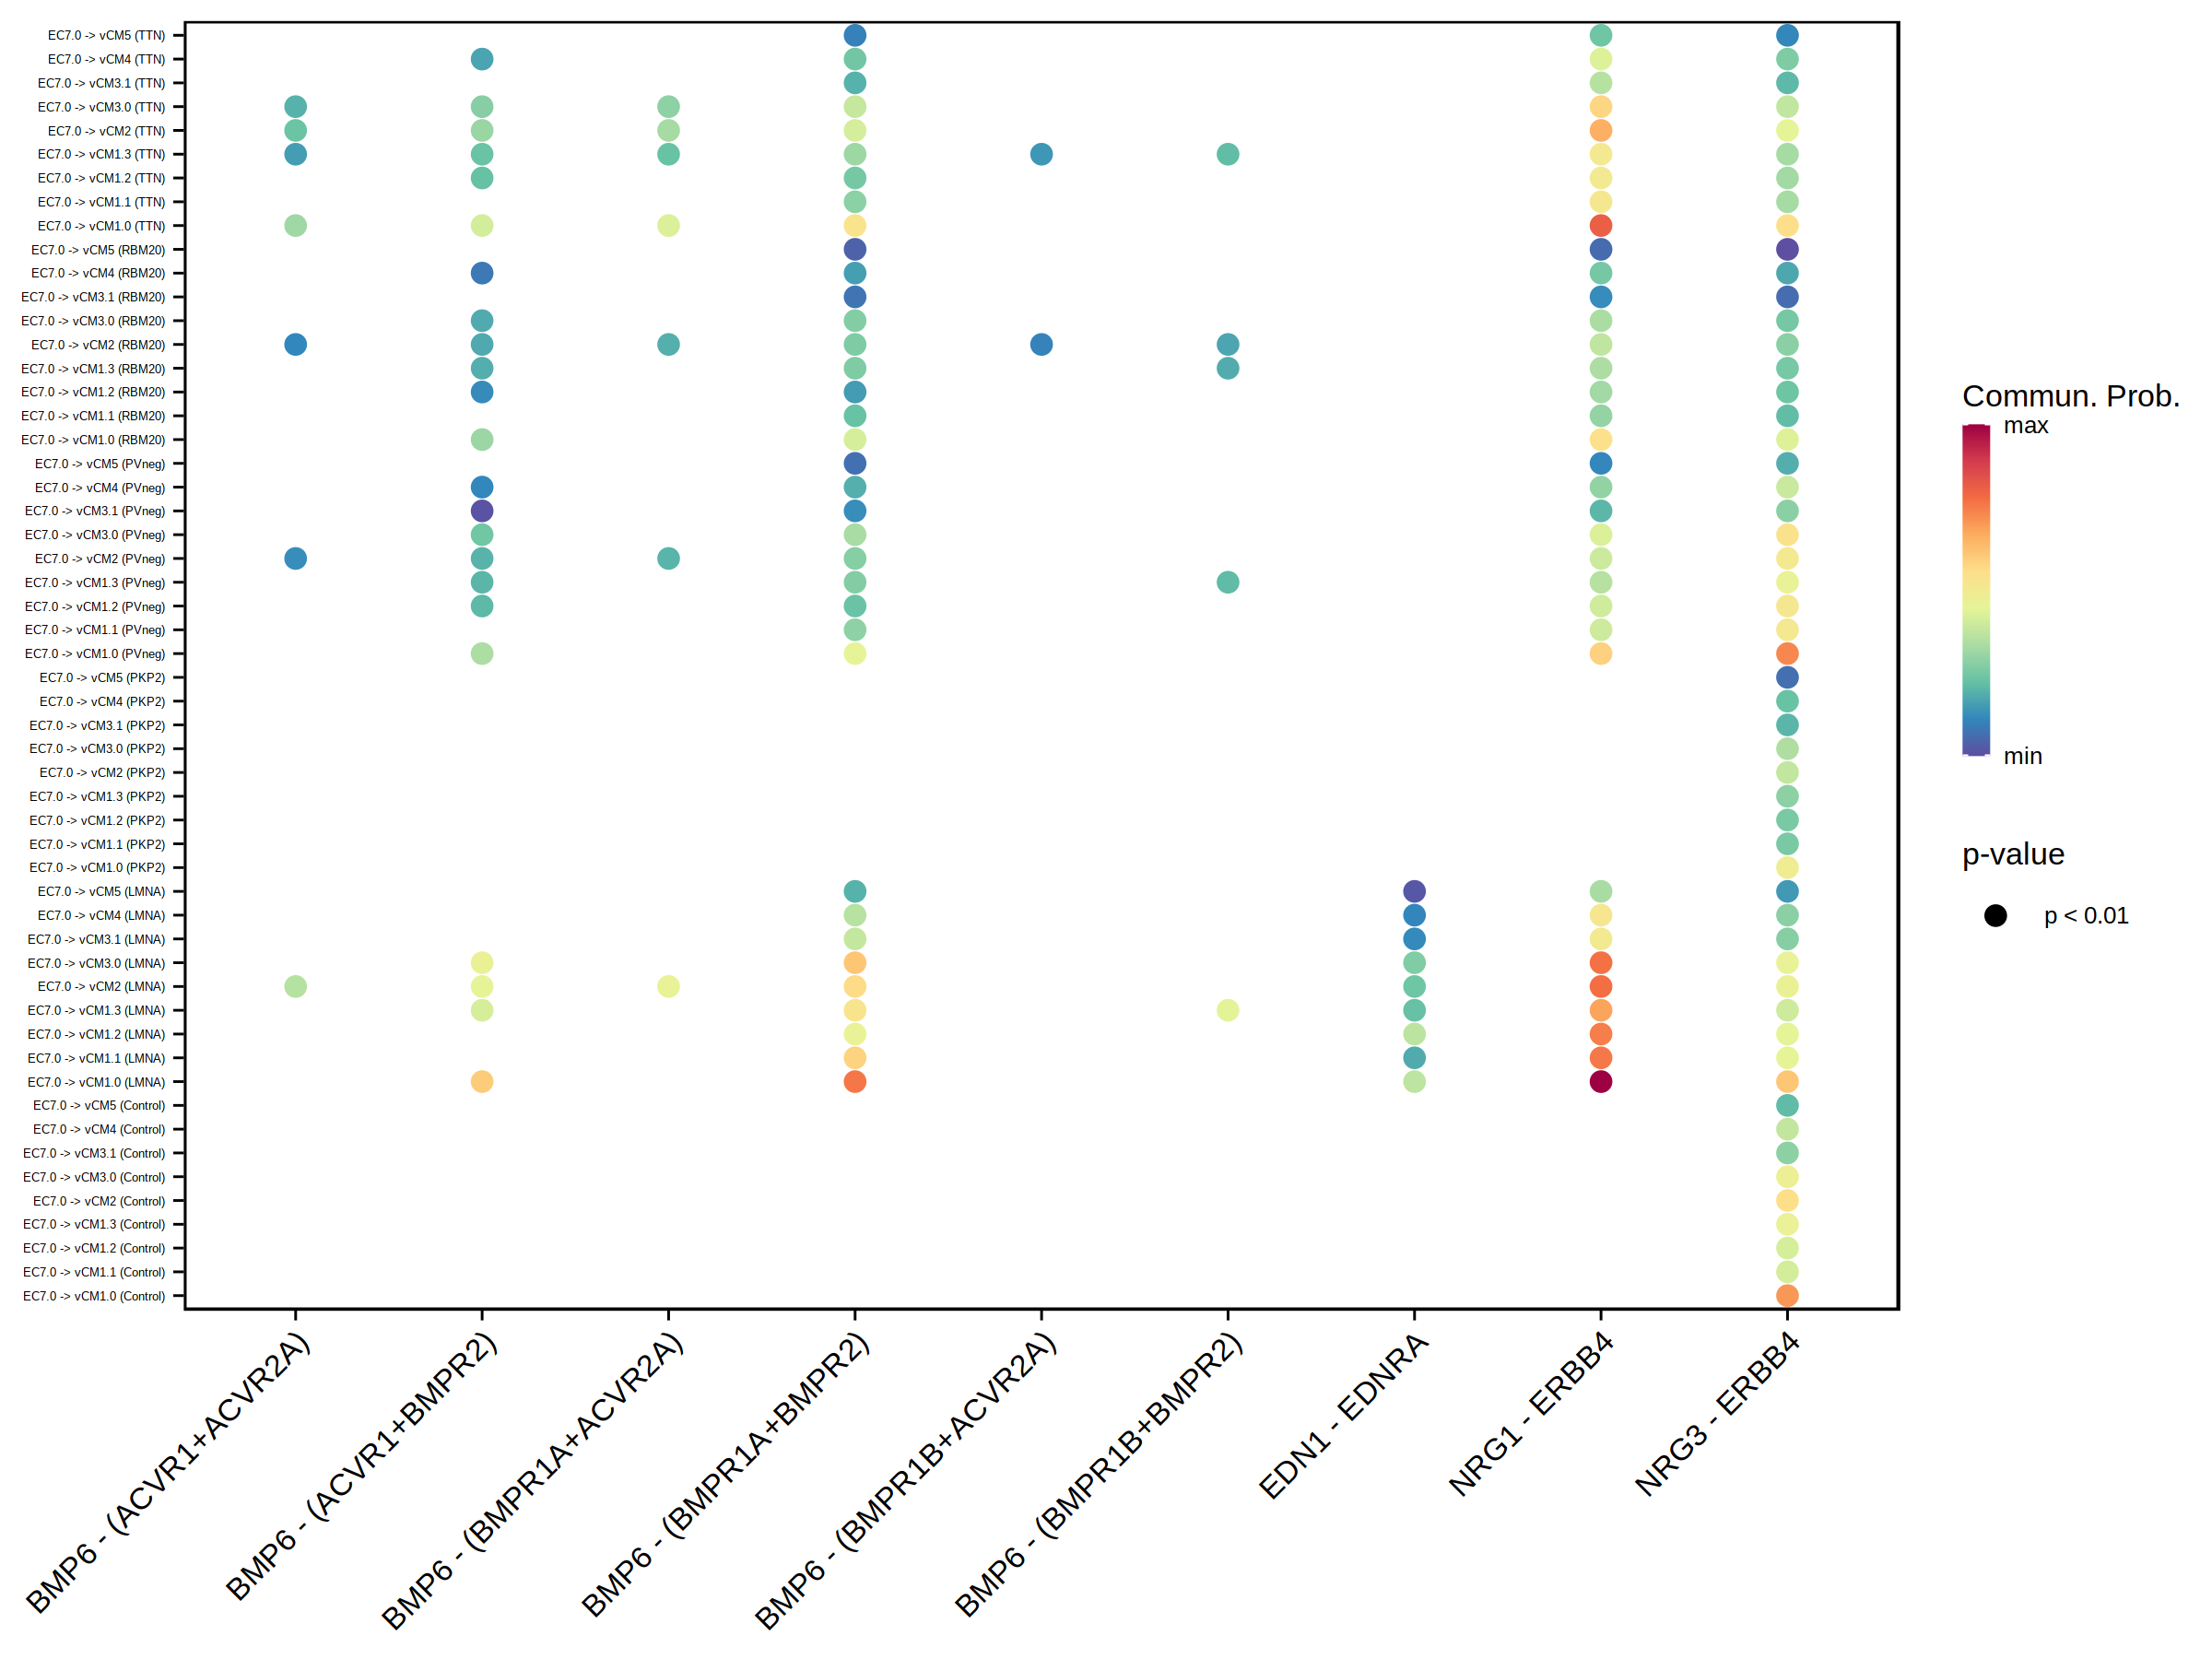

In [10]:
#pdf(width=8,height=6,file="cellchat_ec7_cm_lmna_lv.pdf")

options(repr.plot.width =8, repr.plot.height = 6, repr.plot.res = 300)

netVisual_bubble_2(master_lv, sources.use = "EC7.0",comparison = c(1, 2,3,4,5,6),targets.use = c("vCM1.0","vCM1.1","vCM1.2","vCM1.3","vCM2","vCM3.0","vCM3.1","vCM4","vCM5"), angle.x = 45,  signaling = c("NRG","EDN","BMP")
,text_size.y=3,pch=20,color.heatmap="Spectral",direction=-1,grid.on=FALSE,line.on=FALSE, color.text.use=FALSE,order=TRUE,cex=NULL)


#dev.off()

### Using pch=15, cex=2. heatmap = "Red" with direction =1 - changes dot type and size is not depedent on p-value

Comparing communications on a merged object 


Warning message in RColorBrewer::brewer.pal(n = n.colors, name = color.heatmap):
“n too large, allowed maximum for palette Reds is 9
Returning the palette you asked for with that many colors
”


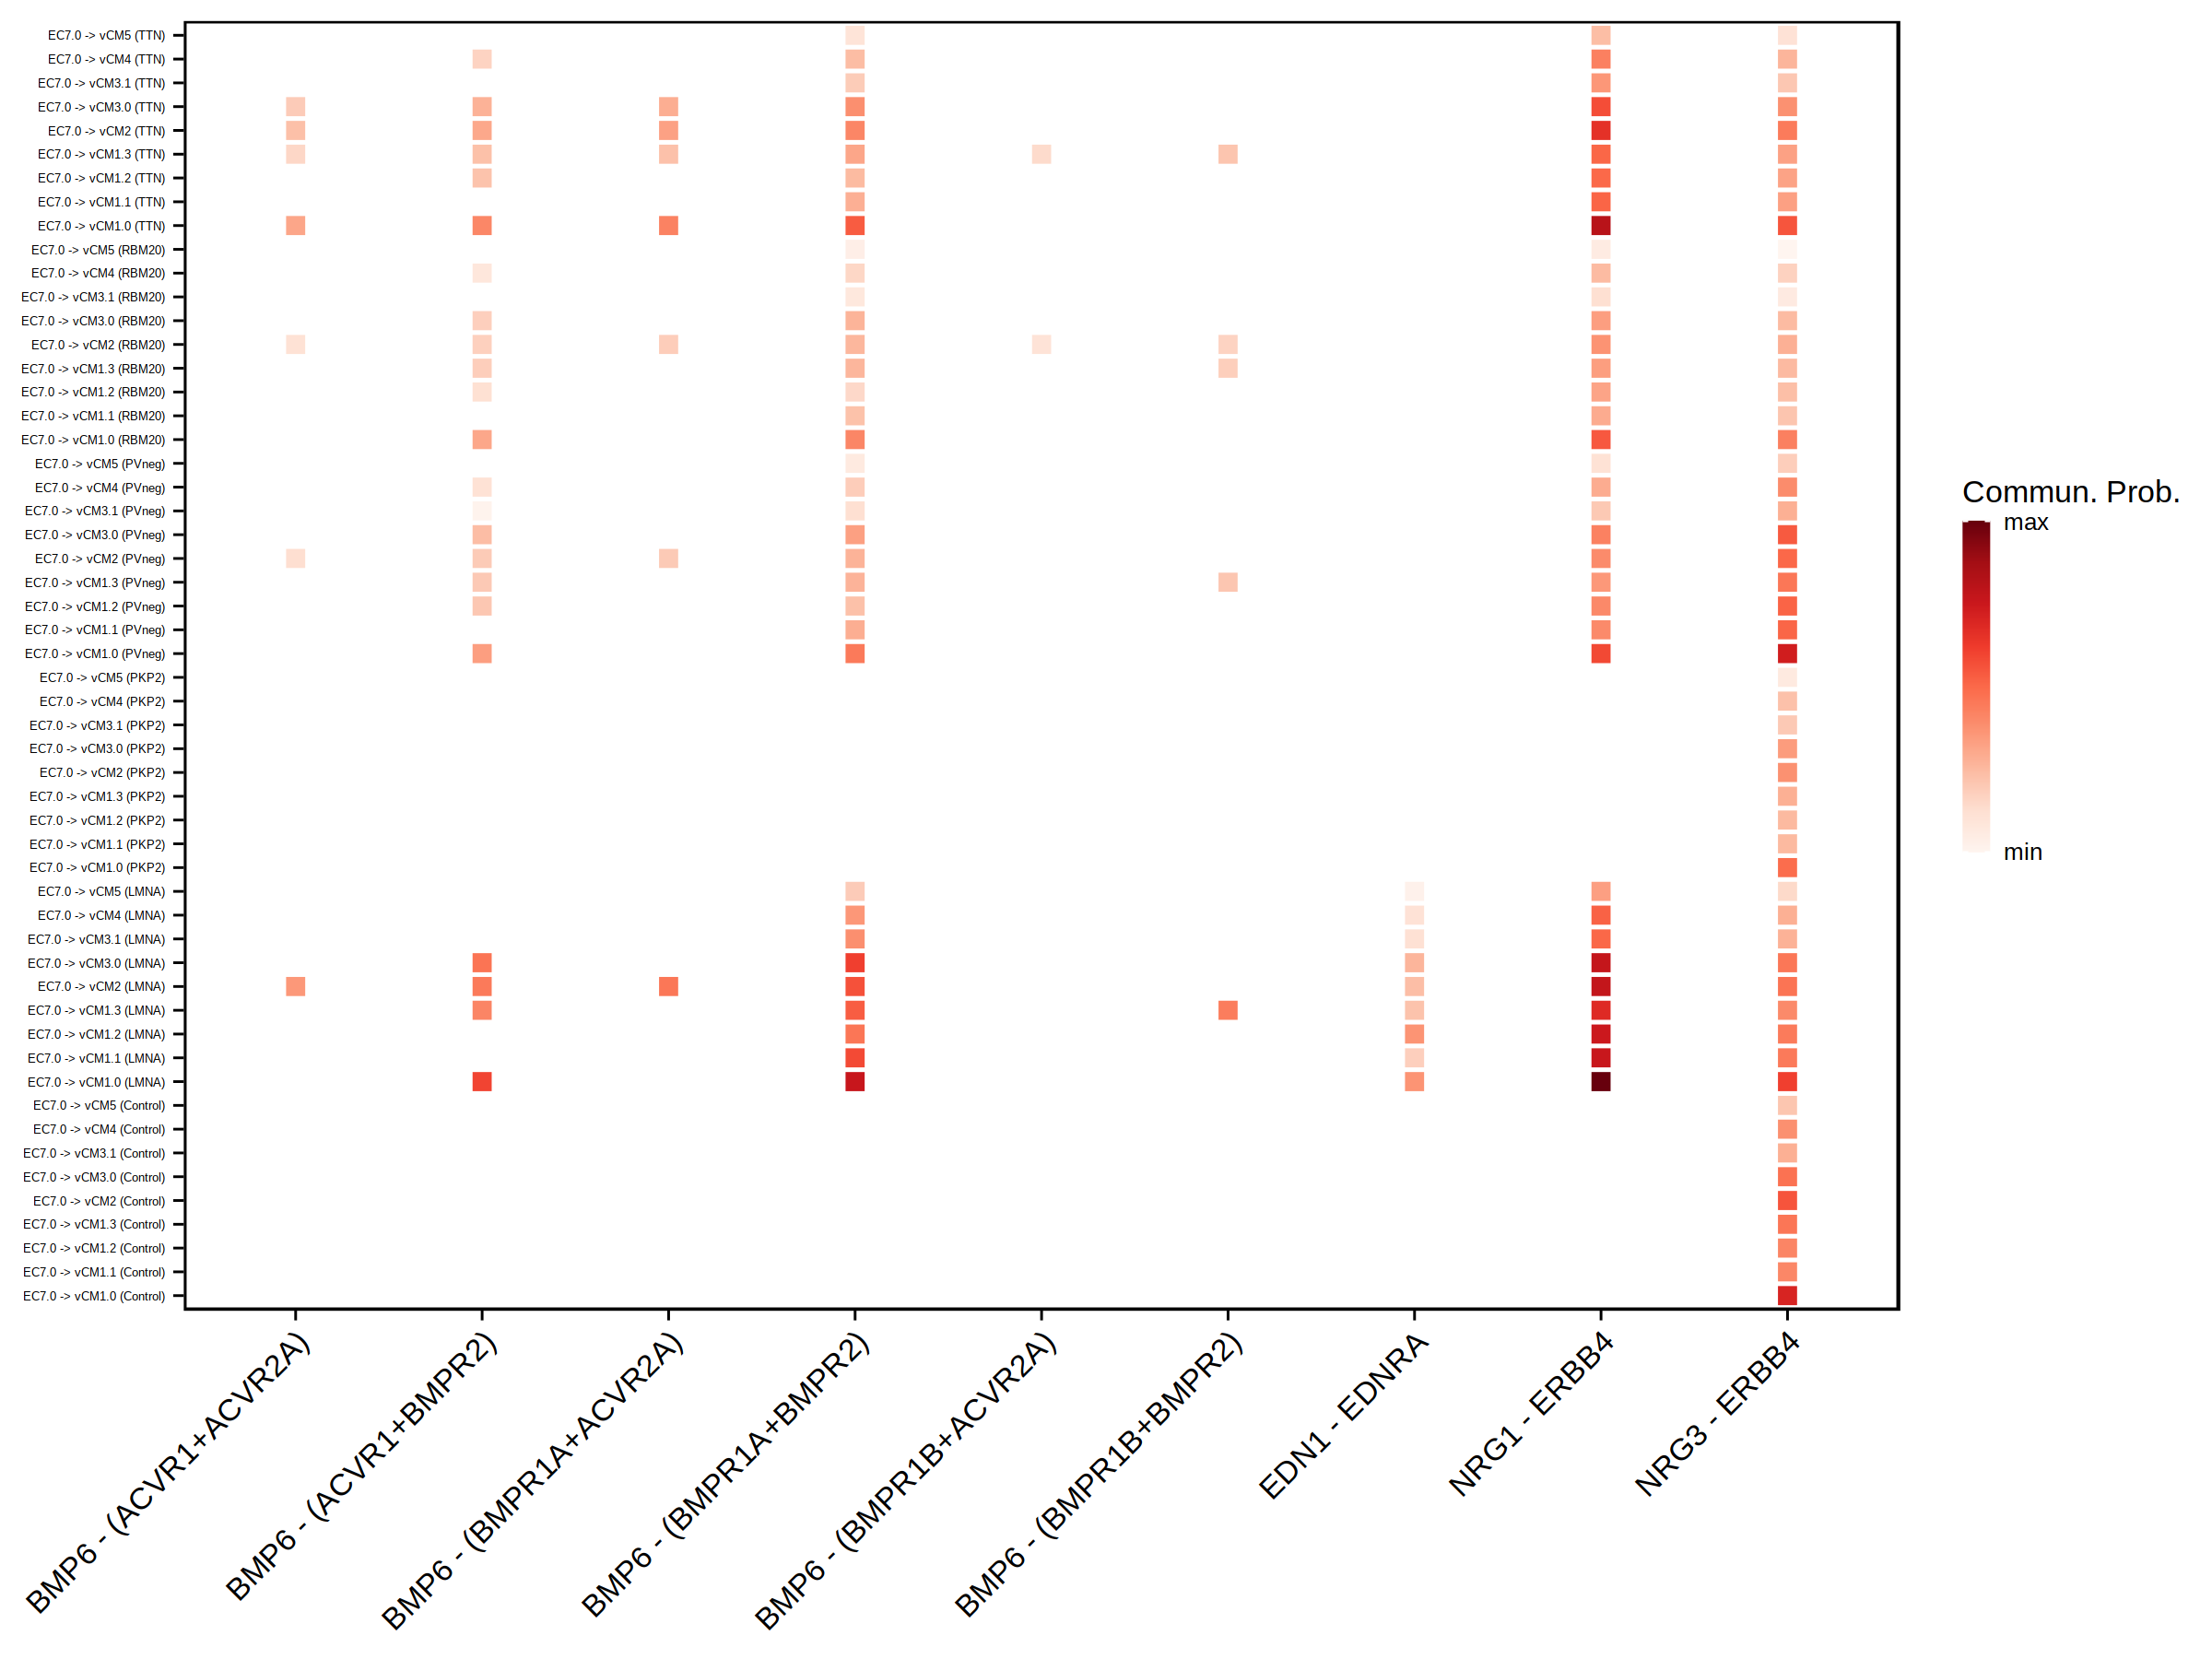

In [11]:
#pdf(width=8,height=6,file="cellchat_ec7_cm_lmna_lv.pdf")

options(repr.plot.width =8, repr.plot.height = 6, repr.plot.res = 300)

netVisual_bubble_2(master_lv, sources.use = "EC7.0",comparison = c(1, 2,3,4,5,6),targets.use = c("vCM1.0","vCM1.1","vCM1.2","vCM1.3","vCM2","vCM3.0","vCM3.1","vCM4","vCM5"), angle.x = 45,  signaling = c("NRG","EDN","BMP")
,text_size.y=3,pch=15,color.heatmap="Reds",direction=1,grid.on=FALSE,line.on=FALSE, color.text.use=FALSE,order=TRUE,cex=2)


#dev.off()

### Using "order" to manually sort the conditions

Comparing communications on a merged object 


Warning message in RColorBrewer::brewer.pal(n = n.colors, name = color.heatmap):
“n too large, allowed maximum for palette Reds is 9
Returning the palette you asked for with that many colors
”
Warning message in if (order == TRUE) {:
“the condition has length > 1 and only the first element will be used”


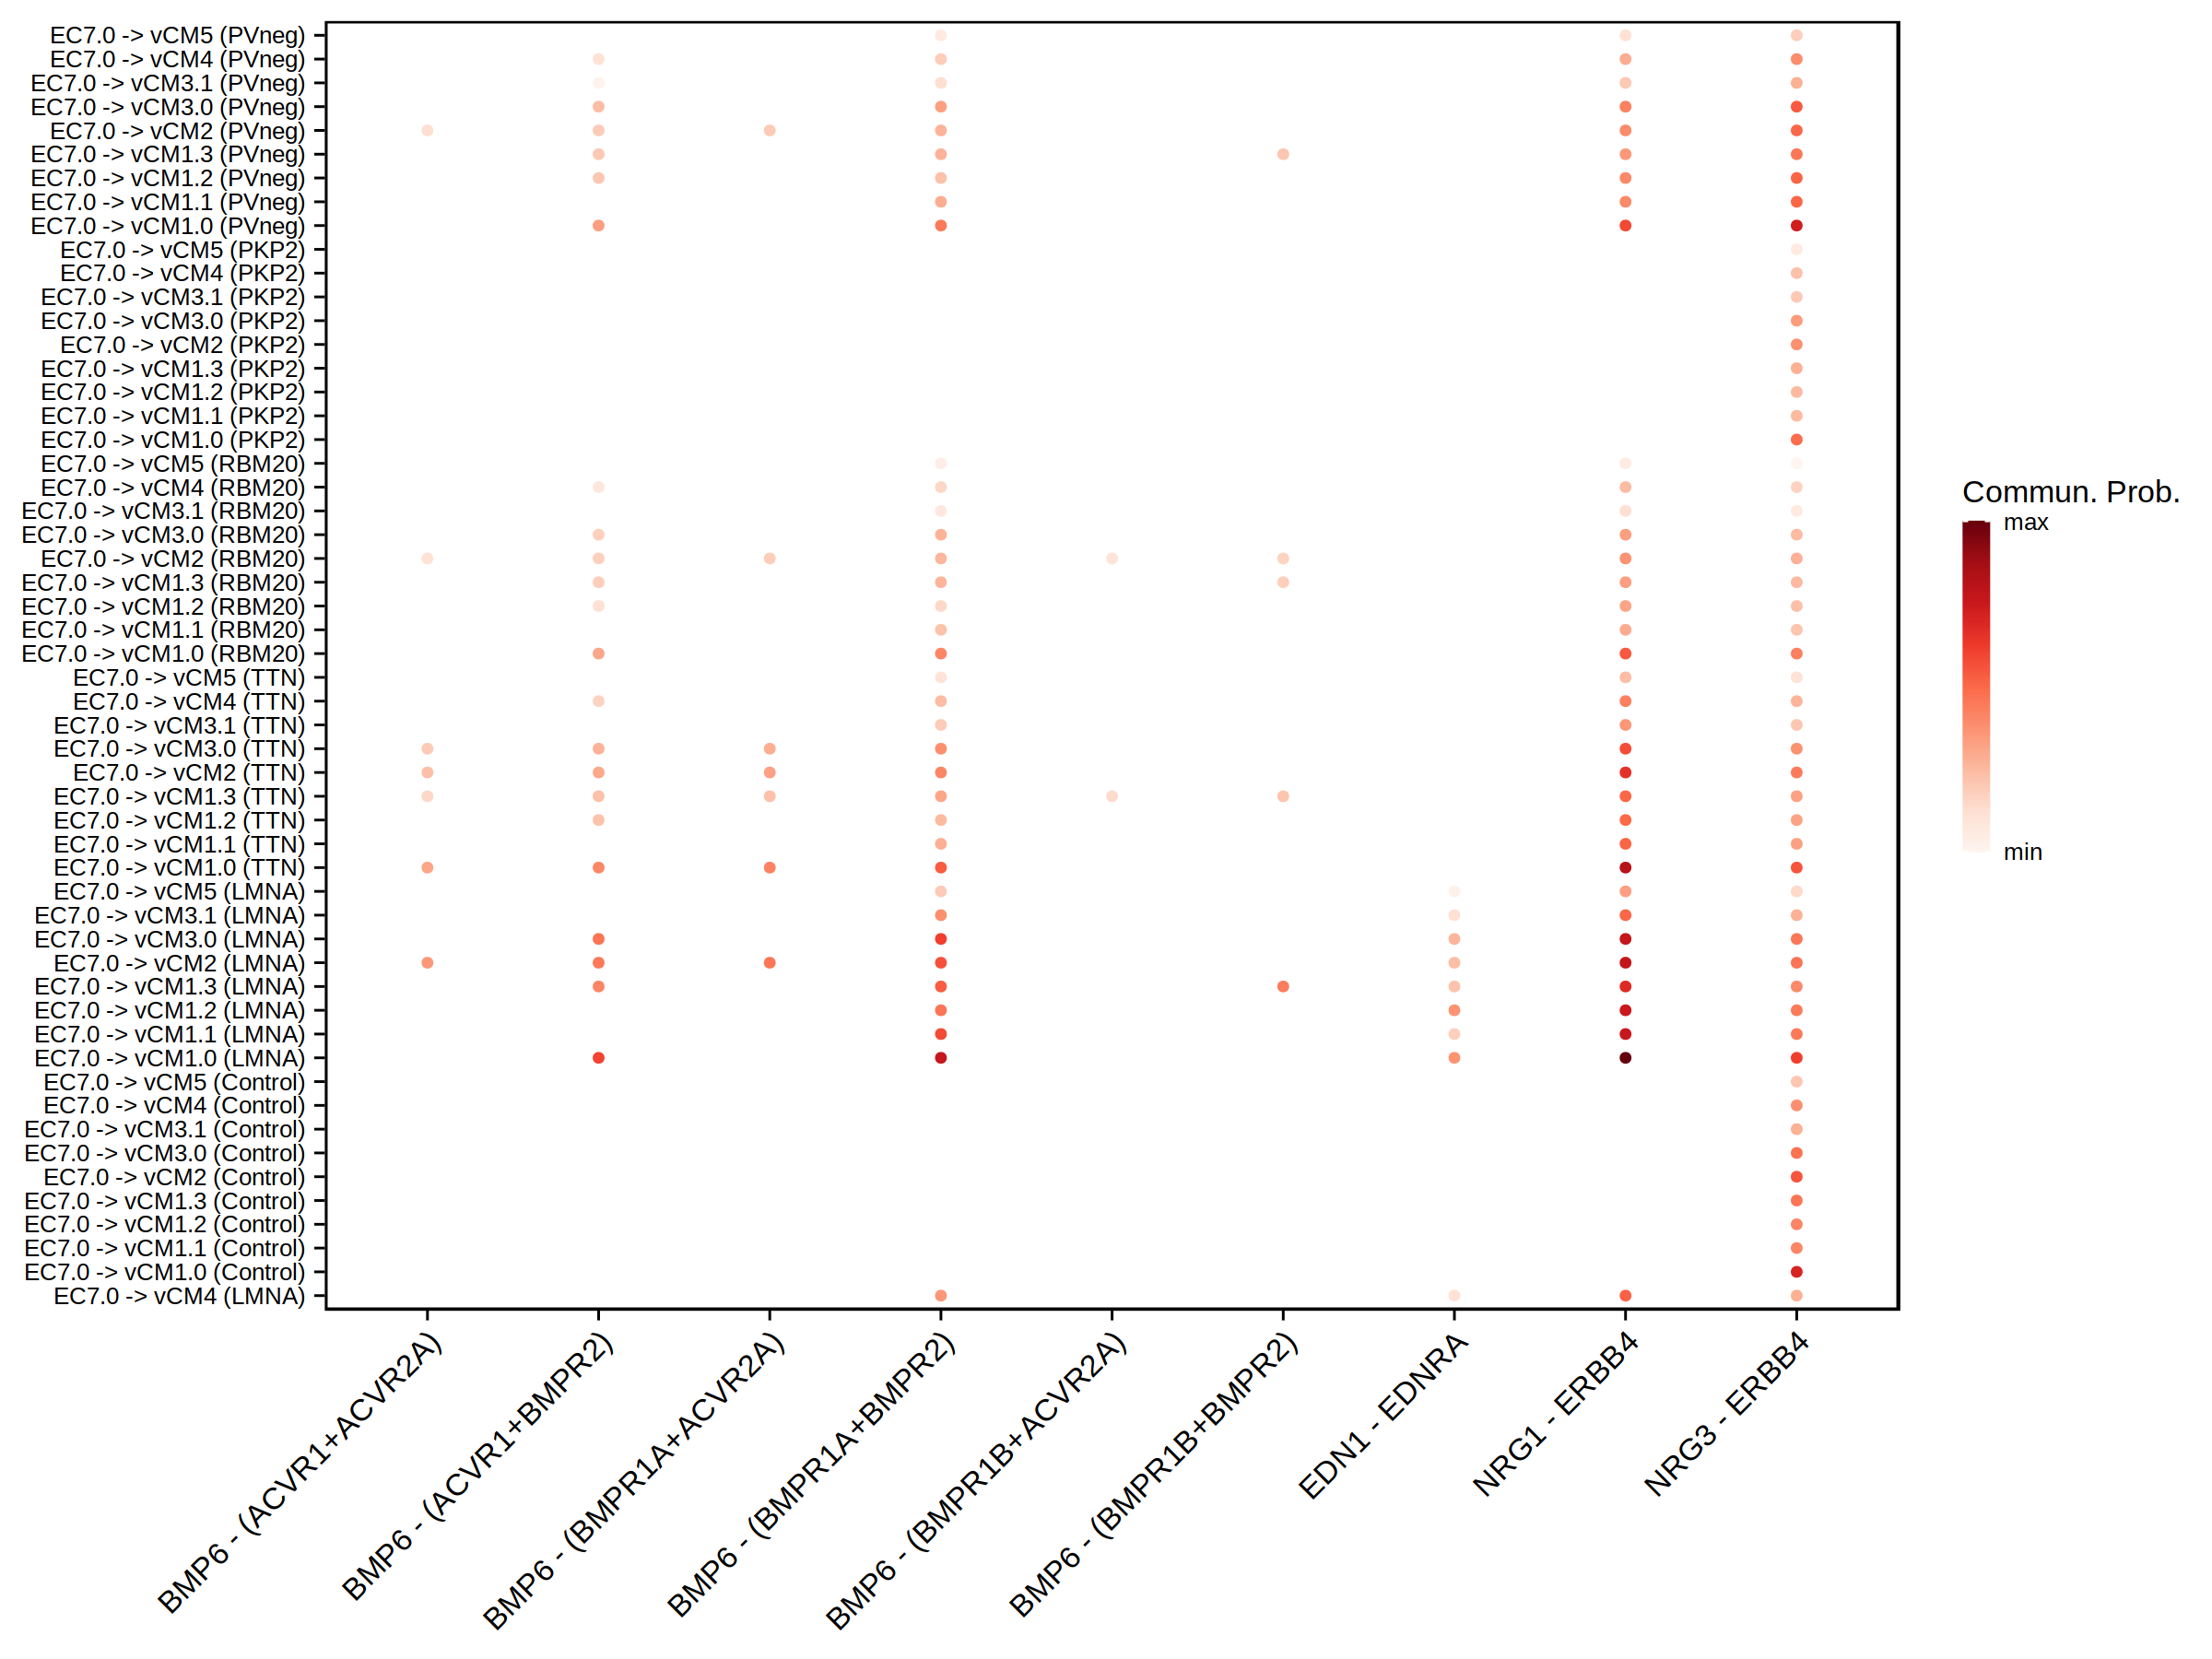

In [12]:
#pdf(width=8,height=6,file="cellchat_ec7_cm_lmna_lv.pdf")

options(repr.plot.width =8, repr.plot.height = 6, repr.plot.res = 300)

netVisual_bubble_2(master_lv, sources.use = "EC7.0", targets.use = c("vCM1.0","vCM1.1","vCM1.2","vCM1.3","vCM2","vCM3.0","vCM3.1","vCM4","vCM5"),  comparison = c(1, 2,3,4,5,6), angle.x = 45,  signaling = c("NRG","BMP","EDN")
,text_size.y=6,pch=20,color.heatmap="Reds",direction=1,grid.on=FALSE,line.on=FALSE, color.text.use=FALSE,order=c( "EC7.0 -> vCM4 (LMNA)","EC7.0 -> vCM1.0 (Control)","EC7.0 -> vCM1.1 (Control)", "EC7.0 -> vCM1.2 (Control)", "EC7.0 -> vCM1.3 (Control)","EC7.0 -> vCM2 (Control)", "EC7.0 -> vCM3.0 (Control)", "EC7.0 -> vCM3.1 (Control)", "EC7.0 -> vCM4 (Control)","EC7.0 -> vCM5 (Control)","EC7.0 -> vCM1.0 (LMNA)","EC7.0 -> vCM1.1 (LMNA)", "EC7.0 -> vCM1.2 (LMNA)", "EC7.0 -> vCM1.3 (LMNA)","EC7.0 -> vCM2 (LMNA)", "EC7.0 -> vCM3.0 (LMNA)", "EC7.0 -> vCM3.1 (LMNA)","EC7.0 -> vCM5 (LMNA)","EC7.0 -> vCM1.0 (TTN)","EC7.0 -> vCM1.1 (TTN)", "EC7.0 -> vCM1.2 (TTN)", "EC7.0 -> vCM1.3 (TTN)","EC7.0 -> vCM2 (TTN)", "EC7.0 -> vCM3.0 (TTN)", "EC7.0 -> vCM3.1 (TTN)", "EC7.0 -> vCM4 (TTN)","EC7.0 -> vCM5 (TTN)","EC7.0 -> vCM1.0 (RBM20)","EC7.0 -> vCM1.1 (RBM20)", "EC7.0 -> vCM1.2 (RBM20)", "EC7.0 -> vCM1.3 (RBM20)","EC7.0 -> vCM2 (RBM20)", "EC7.0 -> vCM3.0 (RBM20)", "EC7.0 -> vCM3.1 (RBM20)", "EC7.0 -> vCM4 (RBM20)","EC7.0 -> vCM5 (RBM20)","EC7.0 -> vCM1.0 (PKP2)","EC7.0 -> vCM1.1 (PKP2)", "EC7.0 -> vCM1.2 (PKP2)", "EC7.0 -> vCM1.3 (PKP2)","EC7.0 -> vCM2 (PKP2)", "EC7.0 -> vCM3.0 (PKP2)", "EC7.0 -> vCM3.1 (PKP2)", "EC7.0 -> vCM4 (PKP2)","EC7.0 -> vCM5 (PKP2)","EC7.0 -> vCM1.0 (PVneg)","EC7.0 -> vCM1.1 (PVneg)", "EC7.0 -> vCM1.2 (PVneg)", "EC7.0 -> vCM1.3 (PVneg)","EC7.0 -> vCM2 (PVneg)", "EC7.0 -> vCM3.0 (PVneg)", "EC7.0 -> vCM3.1 (PVneg)", "EC7.0 -> vCM4 (PVneg)","EC7.0 -> vCM5 (PVneg)")
)

#dev.off()

In [13]:
R.Version()

$platform
[1] "x86_64-conda-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "4"

$minor
[1] "1.0"

$year
[1] "2021"

$month
[1] "05"

$day
[1] "18"

$`svn rev`
[1] "80317"

$language
[1] "R"

$version.string
[1] "R version 4.1.0 (2021-05-18)"

$nickname
[1] "Camp Pontanezen"